In [2]:
import networkx as nx
import numpy as np
import pickle
import gpflow
import os
import warn
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm.notebook import trange
from scipy import sparse
import matplotlib.pyplot as plt

from utils.preprocessing import load_PEMS
from utils.plotting import plot_PEMS

from graph_matern.kernels.graph_matern_kernel import GraphMaternKernel
from graph_matern.kernels.graph_diffusion_kernel import GraphDiffusionKernel

## Fitting A GP - It's probably a better idea to generate from a GP

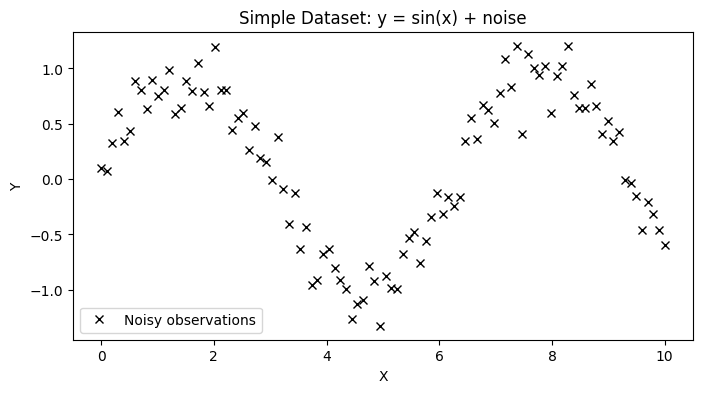

In [3]:
# Create a simple dataset
np.random.seed(42)
X = np.linspace(0, 10, 100)[:, None]  # Input points
Y = np.sin(X) + 0.2 * np.random.randn(*X.shape)  # Noisy outputs

# Plot the dataset
plt.figure(figsize=(8, 4))
plt.plot(X, Y, 'kx', label='Noisy observations')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Simple Dataset: y = sin(x) + noise')
plt.legend()
plt.show()

In [4]:
# Define a kernel (RBF - Radial Basis Function kernel or Squared Exponential kernel)
kernel = gpflow.kernels.SquaredExponential()

# Create a Gaussian Process Regression model
model = gpflow.models.GPR(data=(X, Y), kernel=kernel, mean_function=None)

# Set the likelihood variance to a small value (initial guess)
model.likelihood.variance.assign(0.01)

# Optimize the model parameters using the default optimizer
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(
    model.training_loss, 
    variables=model.trainable_variables,
    options=dict(maxiter=100)
)

# Print the optimized parameters
print_summary = gpflow.utilities.print_summary
print_summary(model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.34567   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.05926   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0326189 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════════════

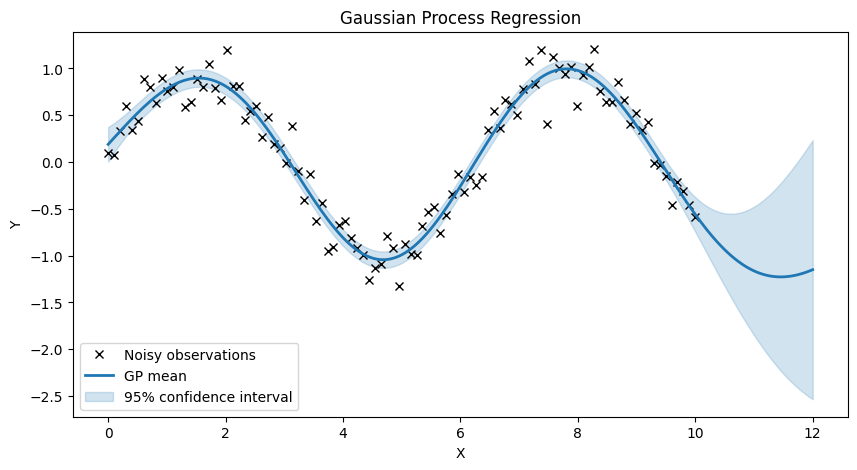

In [5]:
# Create test points for prediction
Xtest = np.linspace(0, 12, 200)[:, None]

# Make predictions (both the mean and variance of the GP)
mean, variance = model.predict_f(Xtest)

# Plot the predictions along with the original data
plt.figure(figsize=(10, 5))
plt.plot(X, Y, 'kx', label='Noisy observations')
plt.plot(Xtest, mean, 'C0', lw=2, label='GP mean')
plt.fill_between(
    Xtest[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(variance[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(variance[:, 0]),
    color='C0', alpha=0.2, label='95% confidence interval'
)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gaussian Process Regression')
plt.legend()
plt.show()

## Fit a GP on Graph

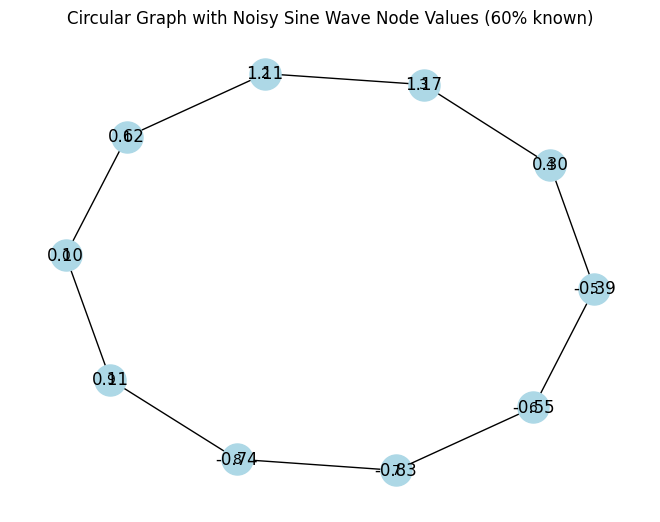

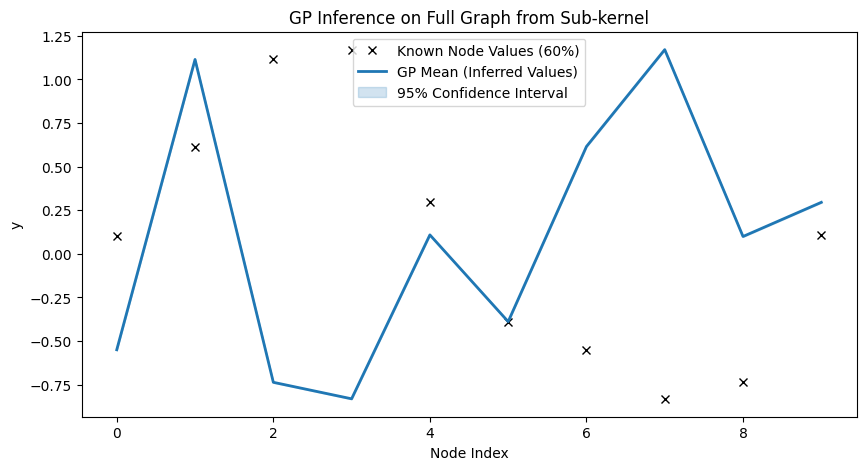

In [6]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
from scipy.linalg import expm

# Create a larger circular graph with 10 nodes
num_nodes = 10
G = nx.cycle_graph(num_nodes)  # A circular graph with 10 nodes

# Create a visible pattern for y values (e.g., sine wave) and add noise
np.random.seed(42)
x = np.linspace(0, 2 * np.pi, num_nodes)
y_values = np.sin(x)  # Sine wave pattern
noise = 0.2 * np.random.randn(num_nodes)  # Adding Gaussian noise with standard deviation of 0.2
y_values_noisy = y_values + noise  # Noisy y-values

# Select 60% of the nodes randomly to assign known values
num_known_nodes = int(num_nodes * 1)
known_indices = np.random.choice(num_nodes, num_known_nodes, replace=False)
unknown_indices = np.array([i for i in range(num_nodes) if i not in known_indices])

# Create input data with 60% known values
X_known = known_indices[:, None].astype(np.float64)  # Node indices as inputs for known nodes
Y_known = y_values_noisy[known_indices][:, None].astype(np.float64)  # Noisy sine wave values as targets

# Visualize the graph with the noisy sine wave node values
pos = nx.spring_layout(G)  # Layout for graph visualization
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
nx.draw_networkx_labels(G, pos, labels={i: f'{y:.2f}' if i in known_indices else 'Unknown' for i, y in enumerate(y_values_noisy)}, font_color='black')
plt.title('Circular Graph with Noisy Sine Wave Node Values (60% known)')
plt.show()

# Define a simple diffusion kernel based on the graph adjacency matrix
def diffusion_kernel(adj_matrix, beta=1.0):
    laplacian = np.diag(np.sum(adj_matrix, axis=1)) - adj_matrix  # Graph Laplacian
    return expm(-beta * laplacian)  # Matrix exponential of (-beta * Laplacian)

# Get the adjacency matrix of the graph
adj_matrix = nx.to_numpy_array(G)

# Compute the diffusion kernel with a beta parameter
K = diffusion_kernel(adj_matrix, beta=0.5)

# Slice the kernel matrix for the training data (sub-kernel for training)
K_train = K[np.ix_(known_indices, known_indices)]

# Define a custom kernel using the precomputed kernel matrix (train sub-kernel for training phase)
class GraphKernel(gpflow.kernels.Kernel):
    def __init__(self, precomputed_kernel_matrix):
        super().__init__()
        self.K_matrix = tf.convert_to_tensor(precomputed_kernel_matrix, dtype=tf.float64)

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        return self.K_matrix[:len(X), :len(X2)]  # Sub-kernel for known nodes

    def K_diag(self, X):
        return tf.linalg.diag_part(self.K_matrix)

# Instantiate the custom Graph Kernel for the training subset
graph_kernel_train = GraphKernel(K_train)

# Build the GP model using the sub-kernel and the training data
model = gpflow.models.GPR(data=(X_known, Y_known), kernel=graph_kernel_train, mean_function=None)

# Set the likelihood variance (initial guess)
model.likelihood.variance.assign(0.01)

# Optimize the model
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(
    model.training_loss, 
    variables=model.trainable_variables,
    options=dict(maxiter=100)
)

# Use the full kernel matrix (K) for prediction over all nodes
class GraphKernelFull(gpflow.kernels.Kernel):
    def __init__(self, precomputed_kernel_matrix):
        super().__init__()
        self.K_matrix = tf.convert_to_tensor(precomputed_kernel_matrix, dtype=tf.float64)

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        return self.K_matrix[:len(X), :len(X2)]  # Full kernel matrix for all nodes

    def K_diag(self, X):
        return tf.linalg.diag_part(self.K_matrix)

# Instantiate the custom Graph Kernel for full prediction
graph_kernel_full = GraphKernelFull(K)
model.kernel = graph_kernel_full  # Replace the training kernel with the full kernel for prediction

# Predict the values for all nodes (including the unknown ones)
X_all = np.arange(num_nodes)[:, None].astype(np.float64)  # All node indices for prediction
mean, variance = model.predict_f(X_all)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(known_indices, Y_known, 'kx', label='Known Node Values (60%)')
plt.plot(X_all, mean, 'C0', lw=2, label='GP Mean (Inferred Values)')
plt.fill_between(
    X_all[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(variance[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(variance[:, 0]),
    color='C0', alpha=0.2, label='95% Confidence Interval'
)
plt.xlabel('Node Index')
plt.ylabel('y')
plt.title('GP Inference on Full Graph from Sub-kernel')
plt.legend()
plt.show()

# Print predictions for unknown nodes
for i in unknown_indices:
    print(f'Predicted value for Node {i}: {mean[i][0]:.2f} (True value: {y_values_noisy[i]:.2f})')


In [7]:
model.trainable_parameters

(<Parameter: name=chain_of_shift_of_softplus, dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=1.46812834802994e-06>,)